## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 302,218
Trainable params:

Your experiments come here:

In [11]:
import torch.optim as optim

lr = 5e-4

model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30

def train_fasion(model, train_loader, opt, loss_func, num_epochs=10):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            
            
            out = model(data)
            loss = loss_func(out, target)
            
           
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_train_loss += loss.item()

            _, predicted = torch.max(out.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss.append(epoch_train_loss / len(train_loader))
        train_acc.append(correct_train / total_train)


        model.eval()
        epoch_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                out = model(data)
                loss = loss_func(out, target) 
                epoch_test_loss += loss.item()
                _, predicted = torch.max(out.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_loss.append(epoch_test_loss / len(test_loader))
        test_acc.append(correct_test / total_test)

        print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Acc: {:.3f} \tTest Loss: {:.6f} \tTest Accuracy: {:.3f}'.format(
            epoch, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))

    return train_loss, train_acc, test_loss, test_acc, model


# Your experiments, training and validation loops here

train_loss_1, train_acc_1, test_loss_1, test_acc_1, model_1 = train_fasion(model, train_loader, opt, loss_func, num_epochs=num_epochs)

Epoch: 0 	Train Loss: 0.567745 	Train Acc: 0.815 	Test Loss: 0.398015 	Test Accuracy: 0.852
Epoch: 1 	Train Loss: 0.388522 	Train Acc: 0.859 	Test Loss: 0.382754 	Test Accuracy: 0.858
Epoch: 2 	Train Loss: 0.348653 	Train Acc: 0.873 	Test Loss: 0.346153 	Test Accuracy: 0.871
Epoch: 3 	Train Loss: 0.328486 	Train Acc: 0.880 	Test Loss: 0.330208 	Test Accuracy: 0.879
Epoch: 4 	Train Loss: 0.309915 	Train Acc: 0.886 	Test Loss: 0.327956 	Test Accuracy: 0.876
Epoch: 5 	Train Loss: 0.295080 	Train Acc: 0.891 	Test Loss: 0.366657 	Test Accuracy: 0.865
Epoch: 6 	Train Loss: 0.285528 	Train Acc: 0.894 	Test Loss: 0.311485 	Test Accuracy: 0.887
Epoch: 7 	Train Loss: 0.274906 	Train Acc: 0.898 	Test Loss: 0.323643 	Test Accuracy: 0.880
Epoch: 8 	Train Loss: 0.266655 	Train Acc: 0.901 	Test Loss: 0.302694 	Test Accuracy: 0.887
Epoch: 9 	Train Loss: 0.255682 	Train Acc: 0.905 	Test Loss: 0.299707 	Test Accuracy: 0.892
Epoch: 10 	Train Loss: 0.249276 	Train Acc: 0.908 	Test Loss: 0.342962 	Test Acc

In [12]:
def plot_func(train_loss, train_acc, test_loss, test_acc, name=""):
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label=f'Train Loss for {name}NeuralNetwork')
    # plt.plot(range(1, len(test_losses_relu1) + 1), test_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
    plt.plot(range(1, len(test_loss) + 1), test_loss, marker='o', label=f'Test Loss for {name}NeuralNetwork')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.grid(True)
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label=f'Train Accuracy for {name}NeuralNetwork')
    # plt.plot(range(1, len(test_accuracies_relu1) + 1), test_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
    plt.plot(range(1, len(test_acc) + 1), test_acc, marker='o', label=f'Test Accuracy for {name}NeuralNetwork')
    plt.axhline(y=0.885, color='r', linestyle='--', label='Target Accuracy (0.885)') # Горизонтальная линия
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.grid(True)
    plt.legend()
    plt.suptitle('Comparison of Loss and Accuracy for Train and Test data')
    plt.tight_layout()

    plt.show()

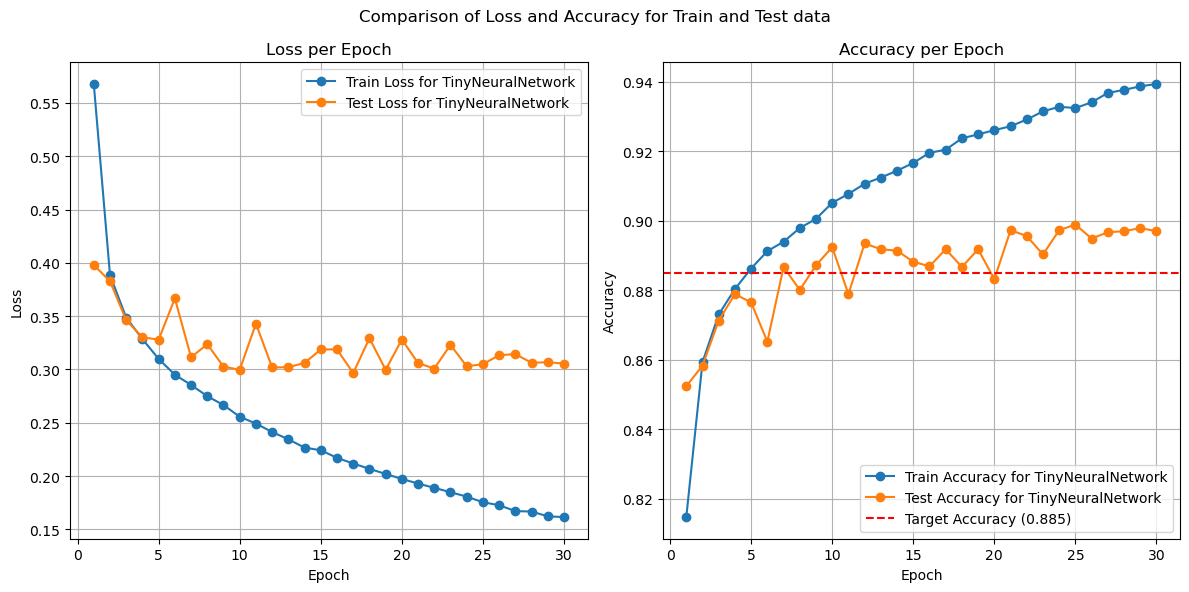

In [13]:
plot_func(train_loss_1, train_acc_1, test_loss_1, test_acc_1, 'Tiny')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
           Linear-10                   [-1, 10]          40,970
Total params: 53,600,266
Trainable params: 53,600,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 204.47
Est

In [16]:
# Уменьшаем размер обучающего набора данных для того чтобы модель гарантированно переобучилась

small_train_set = torch.utils.data.Subset(fmnist_dataset_train, range(2000))
small_train_loader = torch.utils.data.DataLoader(small_train_set, batch_size=128, shuffle=True, num_workers=2)

In [17]:
model = OverfittingNeuralNetwork().to(device)
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE


lr = 1e-3
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

num_epochs = 50

train_loss_2, train_acc_2, test_loss_2, test_acc_2, model_2 = train_fasion(model, small_train_loader, opt, loss_func, num_epochs=num_epochs)
# Your experiments, come here

Epoch: 0 	Train Loss: 1.649021 	Train Acc: 0.393 	Test Loss: 0.978903 	Test Accuracy: 0.604
Epoch: 1 	Train Loss: 0.858185 	Train Acc: 0.662 	Test Loss: 0.778735 	Test Accuracy: 0.688
Epoch: 2 	Train Loss: 0.628258 	Train Acc: 0.756 	Test Loss: 0.682861 	Test Accuracy: 0.747
Epoch: 3 	Train Loss: 0.587424 	Train Acc: 0.779 	Test Loss: 0.681365 	Test Accuracy: 0.765
Epoch: 4 	Train Loss: 0.506349 	Train Acc: 0.814 	Test Loss: 0.614409 	Test Accuracy: 0.783
Epoch: 5 	Train Loss: 0.431381 	Train Acc: 0.844 	Test Loss: 0.636089 	Test Accuracy: 0.757
Epoch: 6 	Train Loss: 0.410397 	Train Acc: 0.842 	Test Loss: 0.672309 	Test Accuracy: 0.788
Epoch: 7 	Train Loss: 0.430924 	Train Acc: 0.844 	Test Loss: 0.606687 	Test Accuracy: 0.794
Epoch: 8 	Train Loss: 0.409309 	Train Acc: 0.853 	Test Loss: 0.714197 	Test Accuracy: 0.771
Epoch: 9 	Train Loss: 0.371716 	Train Acc: 0.861 	Test Loss: 0.650654 	Test Accuracy: 0.788
Epoch: 10 	Train Loss: 0.271457 	Train Acc: 0.893 	Test Loss: 0.630530 	Test Acc

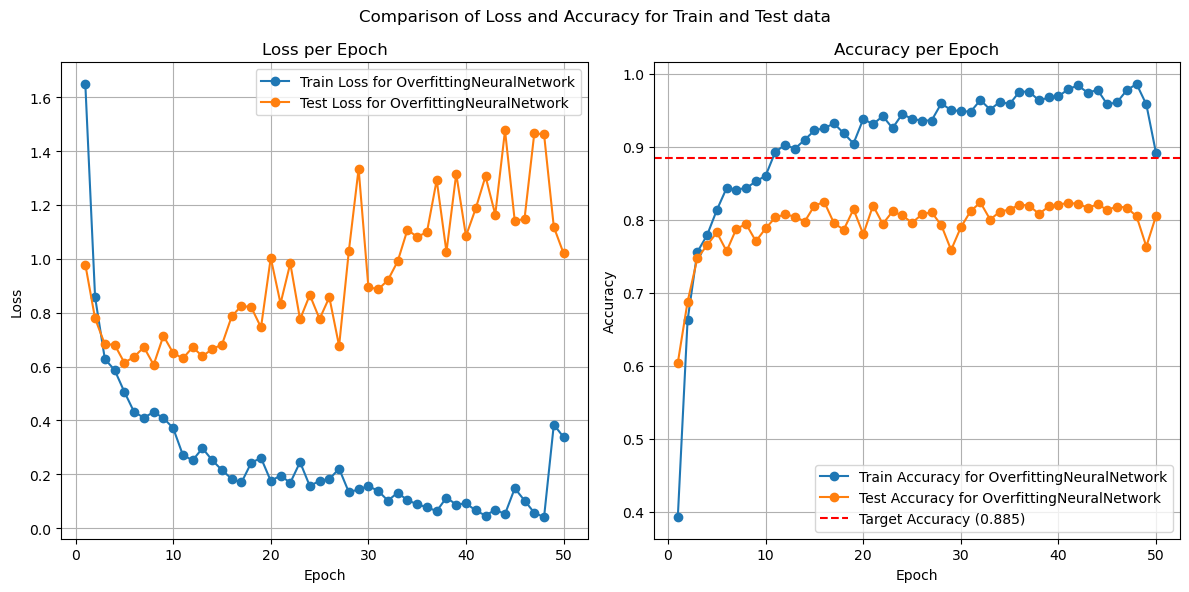

In [ ]:

plot_func(train_loss_2, train_acc_2, test_loss_2, test_acc_2, 'Overfitting')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [34]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [35]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
          Dropout-12                 [-1, 4096]               0
             ReLU-13                 [-1, 4096]               0
           Linear-14                 [-

In [36]:
# Сделаем еще один небольшой набор данных на 50% больше чем маленький, для того, чтобы показать, что размер датасета тоже 
# является стабилизирующим обучение параметром

medium_train_set = torch.utils.data.Subset(fmnist_dataset_train, range(4000))
medium_train_loader = torch.utils.data.DataLoader(medium_train_set, batch_size=128, shuffle=True, num_workers=2)

In [37]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()



lr = 1e-3

num_epochs = 50

train_loss_3, train_acc_3, test_loss_3, test_acc_3, model_3 = train_fasion(model, medium_train_loader, opt, loss_func, num_epochs=num_epochs)
# Your experiments, come here

Epoch: 0 	Train Loss: 1.480094 	Train Acc: 0.497 	Test Loss: 0.983949 	Test Accuracy: 0.691
Epoch: 1 	Train Loss: 0.949270 	Train Acc: 0.678 	Test Loss: 0.704776 	Test Accuracy: 0.747
Epoch: 2 	Train Loss: 0.795489 	Train Acc: 0.707 	Test Loss: 0.626012 	Test Accuracy: 0.769
Epoch: 3 	Train Loss: 0.682889 	Train Acc: 0.743 	Test Loss: 0.583509 	Test Accuracy: 0.784
Epoch: 4 	Train Loss: 0.641409 	Train Acc: 0.760 	Test Loss: 0.574739 	Test Accuracy: 0.792
Epoch: 5 	Train Loss: 0.623308 	Train Acc: 0.771 	Test Loss: 0.567823 	Test Accuracy: 0.788
Epoch: 6 	Train Loss: 0.596262 	Train Acc: 0.789 	Test Loss: 0.540907 	Test Accuracy: 0.808
Epoch: 7 	Train Loss: 0.595482 	Train Acc: 0.787 	Test Loss: 0.568167 	Test Accuracy: 0.807
Epoch: 8 	Train Loss: 0.560698 	Train Acc: 0.796 	Test Loss: 0.531790 	Test Accuracy: 0.816
Epoch: 9 	Train Loss: 0.528627 	Train Acc: 0.812 	Test Loss: 0.520474 	Test Accuracy: 0.815
Epoch: 10 	Train Loss: 0.520849 	Train Acc: 0.811 	Test Loss: 0.547541 	Test Acc

In [64]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
          Dropout-12                 [-1, 4096]               0
             ReLU-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
num_epochs = 75
model1 = FixedNeuralNetwork().to(device)
opt = optim.SGD(model1.parameters(), momentum=0.3, lr=0.05)
loss_func = nn.CrossEntropyLoss()
train_loss_4, train_acc_4, test_loss_4, test_acc_4, model_4 = train_fasion(model1, medium_train_loader, opt, loss_func, num_epochs=num_epochs)

Epoch: 0 	Train Loss: 5.274461 	Train Acc: 0.144 	Test Loss: 1.984559 	Test Accuracy: 0.321
Epoch: 1 	Train Loss: 2.426963 	Train Acc: 0.380 	Test Loss: 0.947463 	Test Accuracy: 0.642
Epoch: 2 	Train Loss: 1.373079 	Train Acc: 0.560 	Test Loss: 0.972706 	Test Accuracy: 0.667
Epoch: 3 	Train Loss: 1.203100 	Train Acc: 0.613 	Test Loss: 0.964137 	Test Accuracy: 0.666
Epoch: 4 	Train Loss: 1.188918 	Train Acc: 0.629 	Test Loss: 0.953852 	Test Accuracy: 0.678
Epoch: 5 	Train Loss: 1.111456 	Train Acc: 0.658 	Test Loss: 0.822647 	Test Accuracy: 0.725
Epoch: 6 	Train Loss: 0.985406 	Train Acc: 0.678 	Test Loss: 0.848485 	Test Accuracy: 0.727
Epoch: 7 	Train Loss: 0.971286 	Train Acc: 0.693 	Test Loss: 0.806563 	Test Accuracy: 0.718
Epoch: 8 	Train Loss: 0.907150 	Train Acc: 0.718 	Test Loss: 0.733339 	Test Accuracy: 0.731
Epoch: 9 	Train Loss: 0.906801 	Train Acc: 0.713 	Test Loss: 0.653731 	Test Accuracy: 0.765
Epoch: 10 	Train Loss: 0.822958 	Train Acc: 0.725 	Test Loss: 0.669397 	Test Acc

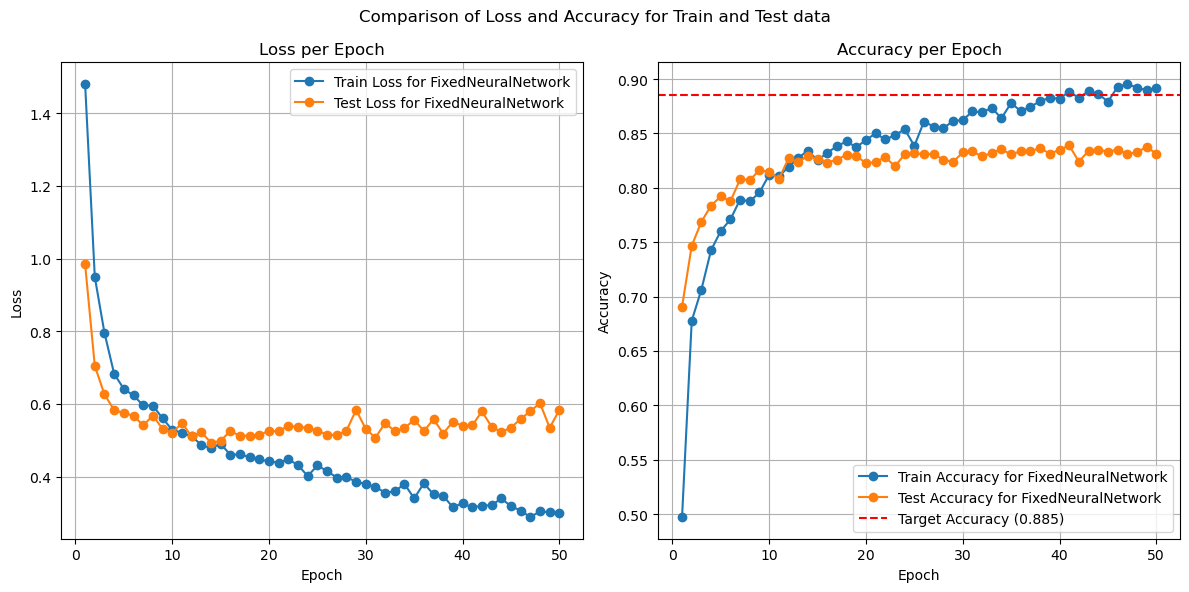

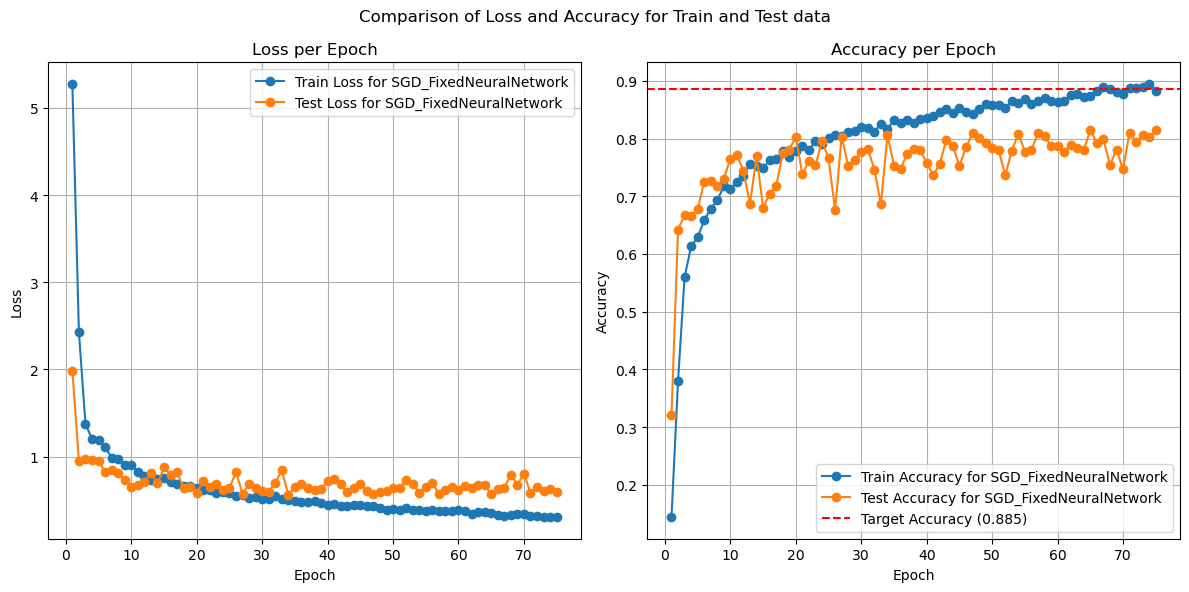

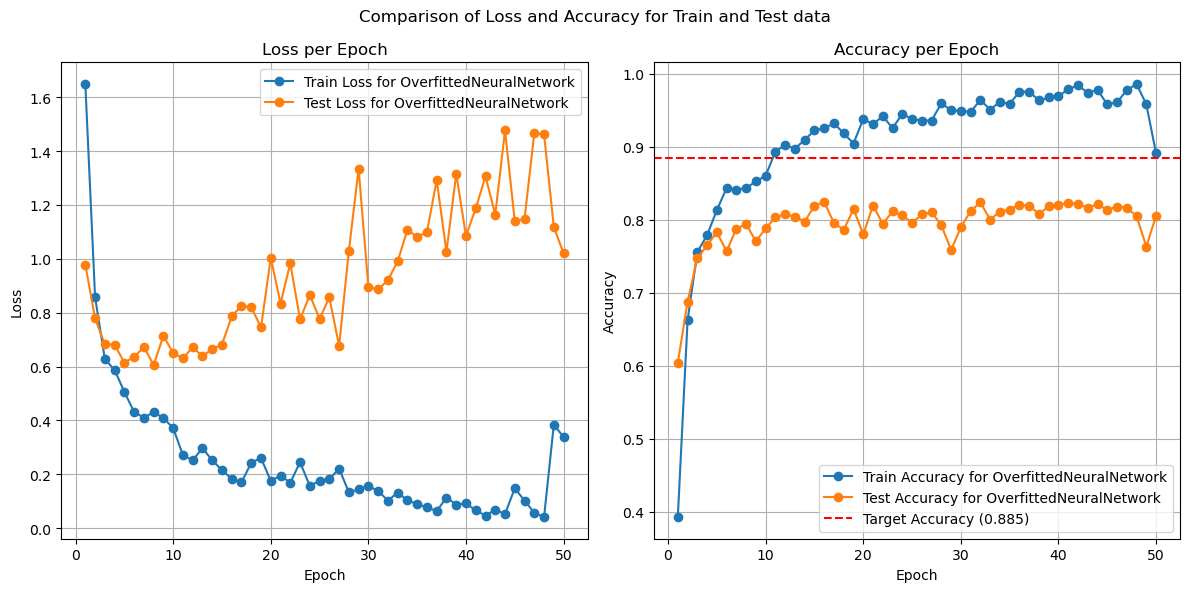

In [66]:
plot_func(train_loss_3, train_acc_3, test_loss_3, test_acc_3, 'Fixed')
plot_func(train_loss_4, train_acc_4, test_loss_4, test_acc_4, 'SGD_Fixed')
plot_func(train_loss_2, train_acc_2, test_loss_2, test_acc_2, 'Overfitted')


### Conclusions:
_Write down small report with your conclusions and your ideas._

**Для регуляризации были использованы:**
* Dropout - уменьшеает количество активных нейронов на каждой итерации обучения, следовательно меньше возможностей "запомнить" данные.
* BatchNormalization - вносится "шум" в бачи данных, что тоже способствует небольшой регуляризации модели.
* Увеличение объема данных, в данном случае на 100% (2000 до 4000), это как своего рода аугментация, которая как раз является одним из способов обучить модель на небольшом наборе данных и не получить переобучения.
* Получилось, что если поменять оптимизатор c Adam на SGD, то лосс на тестовой выборке колеблется в райне плато.

Таким образом получается, что такие методы неявной регуляризации повышают обобщающую способность модели и уменьшают переобучаение.